# Agentic RAG

### GET ENVs

In [1]:
dotenv_path = 'D:\\Dhananjay\\Pro\\DCode\\MyAIPractice\\.env'

# import dotenv
import os
from dotenv import load_dotenv
# Load environment variables
load_dotenv(dotenv_path)

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
GEMINI_LLM_MODEL_NAME = os.getenv("GEMINI_LLM_MODEL_NAME")
GEMINI_EMBEDDING_MODEL_NAME = os.getenv("GEMINI_EMBEDDING_MODEL_NAME")
# GEMINI_LLM_MODEL_NAME = "gemini-2.5-pro-exp-03-25"
# GEMINI_EMBEDDING_MODEL_NAME = "gemini-embedding-exp-03-07"



# Initialize Models

### Initialize Embeddings Model (Google Gemini)

In [2]:
# Initialize Embeddings Model (Google Gemini)

from langchain_google_genai import GoogleGenerativeAIEmbeddings

def get_embedding_model():
    """
    Returns the configured embedding model for vector storage and retrieval.
    """
    google_embedding = GoogleGenerativeAIEmbeddings(
        model=GEMINI_EMBEDDING_MODEL_NAME,
        google_api_key=GEMINI_API_KEY
    )

    return google_embedding

### Initialize LLM (Google Gemini)


In [3]:
# Initialize LLM (Google Gemini)
from langchain_google_genai import ChatGoogleGenerativeAI

def get_llm_model():

    """
    Returns the configured llm model for text generation.
    """
    gemini_2_5 = ChatGoogleGenerativeAI(google_api_key=GEMINI_API_KEY, 
                                        model=GEMINI_LLM_MODEL_NAME,
                                        temprature = 0,
                                        streaming=True)

    return gemini_2_5


In [4]:
get_llm_model().invoke("who are you?")

AIMessage(content='I am a large language model, trained by Google.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-be9694a4-868c-47ed-b0fd-d049a5a015f0-0', usage_metadata={'input_tokens': 4, 'output_tokens': 12, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})

Failed to send compressed multipart ingest: Connection error caused failure to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. Please confirm your internet connection. ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /runs/multipart (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002582E6EFAD0>: Failed to resolve \'api.smith.langchain.com\' ([Errno 11001] getaddrinfo failed)"))'))
Content-Length: 1011
API Key: lsv2_********************************************98


## Load and Chunk Documents

In [5]:

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredWordDocumentLoader


def load_and_chunk_document(docx_path):
    """Loads document and intelligently chunks while preserving section integrity."""
    loader = UnstructuredWordDocumentLoader(docx_path, mode="elements")
    data = loader.load()

    # Extract text and clean it
    text = "\n".join([chunk.page_content.strip() for chunk in data if chunk.page_content.strip()])

    #  chunking
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,  # Large enough to capture a full clause
        chunk_overlap=200,  # Overlap to prevent split clauses
        separators=["\n\n", "\n", ". ", " "],  # Prefer splitting at paragraphs or sentences
    )
    
    chunks = text_splitter.split_text(text)
    
    return chunks

# Load and chunk document
docx_path = "contract_interview.docx"
document_chunks = load_and_chunk_document(docx_path)





### Convert chunks to Langchain Documents

In [6]:
 from langchain_core.documents import Document

# Convert text chunks to LangChain Document objects
documents = [Document(page_content=chunk) for chunk in document_chunks]


# Retriever

First, we index the Docuemnts.

Then we create a retriever tool.

## Add Documents to vectorDB

In [8]:
# Add to vectorDB

from langchain_community.vectorstores import Chroma


vectorstore = Chroma.from_documents(
    documents=documents,
    collection_name="legal-contract-chroma",
    embedding=get_embedding_model(),
    persist_directory="./chroma_langchain_db",  #  save data locally

)

vector_store_retriever = vectorstore.as_retriever()

### Create Retriever Tool

In [52]:
from langchain.tools.retriever import create_retriever_tool

# Create a retriever tool to extract clauses
retriever_tool = create_retriever_tool(
    vector_store_retriever,  
    "retrieve_information",
    "Search and return information"
)

# Define tools list
tools = [retriever_tool]

# Example usage (if integrated in an agent-based workflow)
result = retriever_tool.invoke("What is the meaning of 'Adverse Event' in the context of this agreement?")
print(result)


6.7 Adverse Events.
(a) Definition. For the purposes of this Agreement, “Adverse Event” shall mean any adverse event associated with the use of the Product in humans, whether or not considered drug-related, including but not limited to “adverse event” as defined in ICH guidelines.

6.7 Adverse Events.
(a) Definition. For the purposes of this Agreement, “Adverse Event” shall mean any adverse event associated with the use of the Product in humans, whether or not considered drug-related, including but not limited to “adverse event” as defined in ICH guidelines.

6.7 Adverse Events.
(a) Definition. For the purposes of this Agreement, “Adverse Event” shall mean any adverse event associated with the use of the Product in humans, whether or not considered drug-related, including but not limited to “adverse event” as defined in ICH guidelines.

6.7 Adverse Events.
(a) Definition. For the purposes of this Agreement, “Adverse Event” shall mean any adverse event associated with the use of the Pro

# Agent State

We will define a graph.

A `state` object that it passes around to each `node`.

Our state will be a list of `messages`.

Each `node` in our graph will append to it.

In [10]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Nodes and Edges

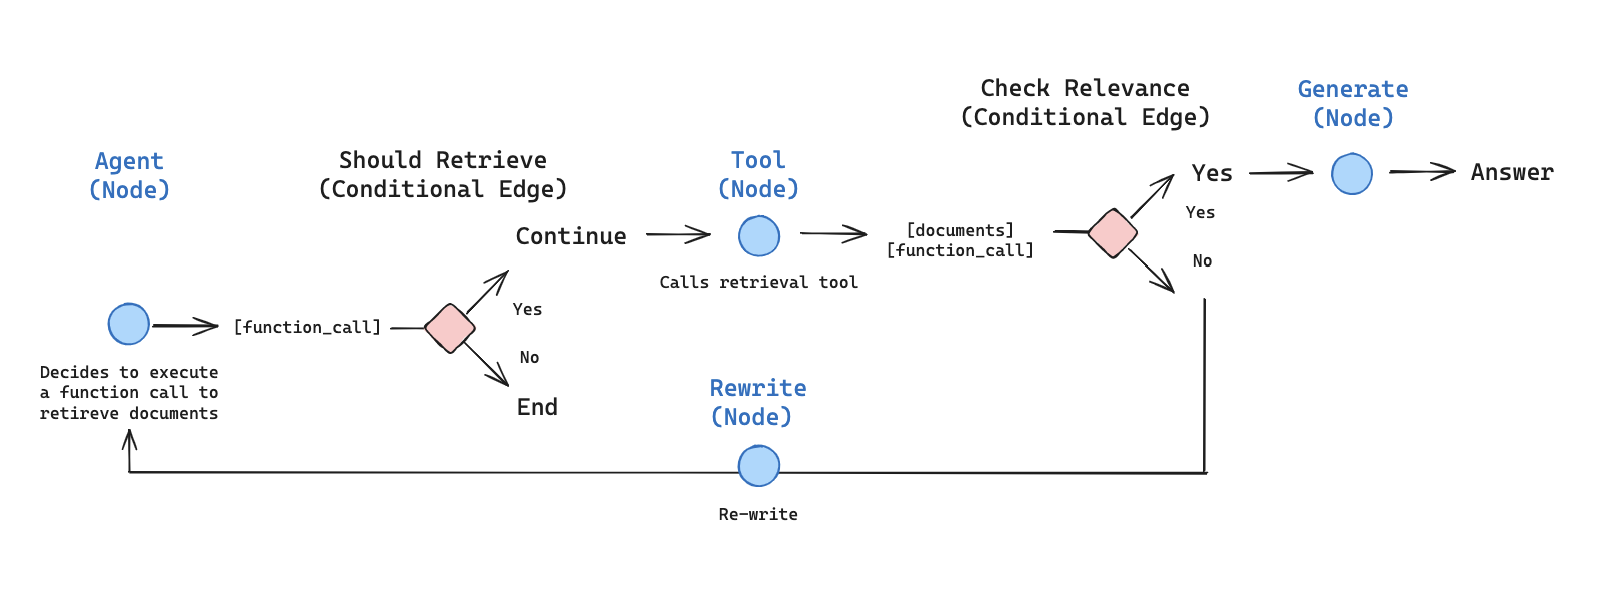

In [11]:
from IPython.display import display
from PIL import Image

# Load and display an image
img = Image.open("Nodes_and_Edges.png")  # Replace with your image path
display(img)


In [36]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    # model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)
    llm = get_llm_model()
    

    # LLM with tool and validation
    llm_with_tool = llm.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    # model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    llm = get_llm_model()
    model = llm.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    # model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    llm = get_llm_model()
    
    response = llm.invoke(msg)
    return {"messages": [response]}



def generate1(state):
    """
    Generate an AI response based on retrieved documents.
    """

    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content  # Retrieved text

    # Ensure docs are not empty
    if not docs.strip():
        return {"messages": [AIMessage(content="No relevant information was found in the document.")]}

    # Prompt for LLM
    prompt_template = """
    You are a legal contract assistant. A user asked about a clause in a contract.  
    The retrieved text from the contract is below:  
      
    ---------  
    {context}  
    ---------  

    Based on this, answer the user's question concisely and clearly.  
    If needed, summarize the retrieved text in simple terms.
    """

    formatted_prompt = prompt_template.format(context=docs)

    # Use Gemini to generate a response
    llm = get_llm_model()
    response = llm.invoke([HumanMessage(content=formatted_prompt)])

    return {"messages": [AIMessage(content=response.content)]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    # llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)
    llm = get_llm_model()

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


# Graph

Start with an agent, call_model

Agent make a decision to call a function

If so, then action to call tool (retriever)

Then call agent with the tool output added to messages (state)

In [37]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant


# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

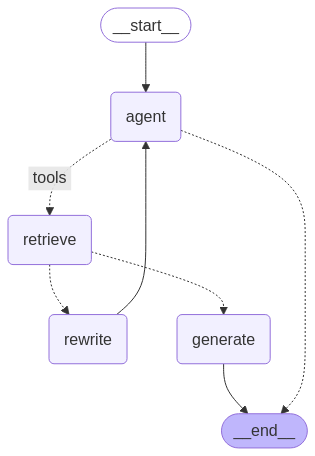

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [39]:
import pprint

query  = input("Aks question to your docuement: ")

inputs = {
    "messages": [
        ("user", query),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

Aks question to your docuement:  hi


---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='Hi, how can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-7361bce7-7c7d-4ba8-832b-692d0f960fb2-0', usage_metadata={'input_tokens': 16, 'output_tokens': 10, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}})]}
'\n---\n'


In [40]:
SYSTEM_PROMPT = """
You are a legal document assistant specializing in retrieving and summarizing contract-related information. 
You assist users by searching for relevant clauses, answering questions based on available contractual content, 
and providing legally sound explanations.

### **Guidelines for Answering Queries:**
- Always prioritize **retrieving relevant information** from the document before generating responses.
- If the retrieved information directly answers the query, provide a **clear and concise** response.
- If relevant information is **not found**, politely state that the document does not contain the requested details.
- For **general legal questions** (outside the document’s scope), provide a disclaimer:  
  *'I am designed to assist with contract-specific queries. For general legal advice, please consult a legal expert.'*
- Maintain **neutral, professional, and factual** language at all times.

### **Handling User Queries:**
- If the query is **directly related** to the document (contract terms, clauses, obligations), extract and summarize the relevant content.
- If the query is **indirectly related** (contract law concepts, legal definitions), provide general guidance but avoid giving legal advice.
- If the query is **irrelevant** (e.g., sports, technology, general AI), politely inform the user that the chatbot focuses on contract-related queries.


"""


In [41]:
from pydantic import BaseModel

class ChatRequest(BaseModel):
    session_id: str  
    message: str

class ChatResponse(BaseModel):
    response: str

    

In [50]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from pydantic import BaseModel

# Define request model
class ChatRequest(BaseModel):
    session_id: str  
    message: str


# Chat Service Class
class ChatService:
    def __init__(self):
        self.graph = graph  # Assuming 'graph' is defined somewhere
        self.chat_histories = {}  # Store session-based chat histories

    def handle_message(self, session_id: str, message: str):
        """Processes user input while maintaining session-based chat history."""
        
        # Initialize session history if not exists
        if session_id not in self.chat_histories:
            self.chat_histories[session_id] = [SystemMessage(content=SYSTEM_PROMPT)]

        # Add user message to session history
        self.chat_histories[session_id].append(HumanMessage(content=message))

        # Prepare state with messages
        state = AgentState(messages=self.chat_histories[session_id])

        # Invoke LangGraph
        next_state = self.graph.invoke(state)

        print(next_state)

        # Extract AI response
        if next_state["messages"]:
            ai_response = next_state["messages"][-1].content
            self.chat_histories[session_id].append(AIMessage(content=ai_response))  # Store AI response
            return ai_response

        return "No response generated."

    def reset_chat_history(self, session_id: str):
        """Clears the chat history for a specific session."""
        self.chat_histories[session_id] = [SystemMessage(content=SYSTEM_PROMPT)]


# Initialize chatbot
chatbot = ChatService()


def chat_endpoint(request: ChatRequest):
    """Handles user messages and maintains session-based chat history."""
    
    # Process user message with session-based chat history
    response = chatbot.handle_message(request.session_id, request.message)

    return {"response": response}




In [51]:
# Test the chatbot
user_input = "ok"
session_id = "1"
request = ChatRequest(session_id=session_id, message=user_input)

response = chat_endpoint(request)
print(response)

---CALL AGENT---
{'messages': [SystemMessage(content="\nYou are a legal document assistant specializing in retrieving and summarizing contract-related information. \nYou assist users by searching for relevant clauses, answering questions based on available contractual content, \nand providing legally sound explanations.\n\n### **Guidelines for Answering Queries:**\n- Always prioritize **retrieving relevant information** from the document before generating responses.\n- If the retrieved information directly answers the query, provide a **clear and concise** response.\n- If relevant information is **not found**, politely state that the document does not contain the requested details.\n- For **general legal questions** (outside the document’s scope), provide a disclaimer:  \n  *'I am designed to assist with contract-specific queries. For general legal advice, please consult a legal expert.'*\n- Maintain **neutral, professional, and factual** language at all times.\n\n### **Handling User Q

In [42]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

# Chat Service Class
class ChatService:
    def __init__(self):
        self.graph = graph
        self.chat_history = [SystemMessage(content=SYSTEM_PROMPT)]  # Store chat history persistently

    def handle_message(self, message: str):
        """Processes user input and maintains chat history."""
        
        # Add user message to history
        self.chat_history.append(HumanMessage(content=message))

        # Prepare state with messages
        state = AgentState(messages=self.chat_history)

        # Invoke LangGraph
        next_state = self.graph.invoke(state)

        print(next_state)

        # Extract AI response
        if next_state["messages"]:
            ai_response = next_state["messages"][-1].content
            self.chat_history.append(AIMessage(content=ai_response))  # Store AI response persistently
            return ai_response

        return "No response generated."

In [43]:
# Store chat histories (simulating user sessions)
chat_histories = {}

# Initialize chatbot
chatbot = ChatService()


def chat_endpoint(request: ChatRequest):
    """Handles user messages and maintains session-based chat history."""

    session_id = request.get("session_id")

    # Initialize chat history for a new session
    if session_id not in chat_histories:
        chat_histories[session_id] = chatbot.chat_history  # Start with system prompt

    # Pass session-specific history to chatbot
    chatbot.chat_history = chat_histories[session_id]

    # Process user message
    response = chatbot.handle_message(request.get("message"))

    # Update session chat history
    chat_histories[session_id] = chatbot.chat_history  

    return {"response": response}

In [44]:
user_input = "What is the role of the Quality Agreement in API manufacturing"

session_id = "1"
request = {"session_id":session_id, "message": user_input}

response = chat_endpoint(request)

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---
{'messages': [SystemMessage(content="\nYou are a legal document assistant specializing in retrieving and summarizing contract-related information. \nYou assist users by searching for relevant clauses, answering questions based on available contractual content, \nand providing legally sound explanations.\n\n### **Guidelines for Answering Queries:**\n- Always prioritize **retrieving relevant information** from the document before generating responses.\n- If the retrieved information directly answers the query, provide a **clear and concise** response.\n- If relevant information is **not found**, politely state that the document does not contain the requested details.\n- For **general legal questions** (outside the document’s scope), provide a disclaimer:  \n  *'I am designed to assist with contract-specific queries. For general legal advice, please consult a legal expert.'*\n- Maintain **neutral, professi

In [45]:
type(response)

dict

In [46]:
response

{'response': 'Okay, I can help with that. Please tell me the user\'s question about the clause. I need to know what they\'re asking in order to provide a concise and clear answer based on the provided text.\n\nFor example, are they asking:\n\n*   "Can manufacture API anywhere they want?"\n*   "What does \'unreasonably withheld or delayed\' mean?"\n*   "What is the Quality Agreement\'s role here?"\n*   "Who is responsible for manufacturing the API?"\n\nOnce I know the question, I can give you a helpful answer.'}

In [47]:
response["response"]

'Okay, I can help with that. Please tell me the user\'s question about the clause. I need to know what they\'re asking in order to provide a concise and clear answer based on the provided text.\n\nFor example, are they asking:\n\n*   "Can manufacture API anywhere they want?"\n*   "What does \'unreasonably withheld or delayed\' mean?"\n*   "What is the Quality Agreement\'s role here?"\n*   "Who is responsible for manufacturing the API?"\n\nOnce I know the question, I can give you a helpful answer.'

In [24]:
for m in response["messages"]:
    m.pretty_print()

KeyError: 'messages'

In [35]:
class ChatService:
    def __init__(self):
        self.graph = graph
        self.chat_histories = {}  # Dictionary to maintain session-wise chat history

    def handle_message(self, session_id: str, message: str):
        """Processes user input while maintaining session-based chat history."""
        
        # Initialize session history if not exists
        if session_id not in self.chat_histories:
            self.chat_histories[session_id] = [SystemMessage(content=SYSTEM_PROMPT)]

        # Add user message to session history
        self.chat_histories[session_id].append(HumanMessage(content=message))

        # Prepare state with messages
        state = AgentState(messages=self.chat_histories[session_id])

        # Invoke LangGraph
        next_state = self.graph.invoke(state)

        # Extract AI response
        if next_state["messages"]:
            ai_response = next_state["messages"][-1].content
            self.chat_histories[session_id].append(AIMessage(content=ai_response))  # Store AI response
            return ai_response

        return "No response generated."

    def reset_chat_history(self, session_id: str):
        """Clears the chat history for a specific session."""
        self.chat_histories[session_id] = [SystemMessage(content=SYSTEM_PROMPT)]
    


In [24]:

# Store chat histories (simulating user sessions)
chat_histories = {}

# Initialize chatbot
chatbot = ChatService()


from pydantic import BaseModel

class ChatRequest(BaseModel):
    session_id: str  
    message: str

class ChatResponse(BaseModel):
    response: str

NameError: name 'SYSTEM_PROMPT' is not defined

### Two sets of questions for testing your RAG pipeline:  


### **1. Questions Related to the Given Document (API Commercial Supply Agreement)**
These questions will test how well your RAG system retrieves relevant information from the document.

#### **Factual Questions:**
1. What is the "API Commercial Supply Agreement," and who are the involved parties?  
2. What is the meaning of "Adverse Event" in the context of this agreement?  
3. What are the obligations of the supplier under the "Minimum Purchase Requirement" clause?  
4. How does the agreement define "Confidential Information"?  
5. What are the responsibilities of the supplier in case of an "API Nonconformity"?  
6. What does the term "Change of Control" refer to in the agreement?  
7. What are the key responsibilities under the "Regulatory Inspections" section?  
8. How are "API Prices" determined according to the agreement?  
9. What steps should be taken if a dispute arises regarding API quality?  
10. What is the role of the "Quality Agreement" in API manufacturing?  

#### **Analytical/Reasoning Questions:**
11. If a supplier fails to meet a Purchase Order deadline, what consequences are outlined in the contract?  
12. How does the agreement ensure compliance with "Current Good Manufacturing Practices" (cGMPs)?  
13. What protections are in place for confidential information shared between parties?  
14. How does the agreement define the responsibilities for "Regulatory Matters"?  
15. In what scenarios can the agreement be terminated?  

---

### **2. Questions NOT Related to the Given Document (General RAG System Testing)**
These questions will test how your RAG system handles irrelevant or out-of-context queries.

#### **Unrelated Factual Questions:**
16. What is the history of the Securities Exchange Act of 1934?  
17. How does the FDA regulate dietary supplements?  
18. What is the process for patenting a pharmaceutical drug in the U.S.?  
19. What are the key components of a commercial contract under U.S. law?  
20. How do international trade agreements affect pharmaceutical supply chains?  

#### **Trick/Confusing Questions:**
21. What are the main differences between quantum computing and classical computing?  
22. Who won the FIFA World Cup in 2022?  
23. What are the latest advancements in artificial intelligence for contract analysis?  
24. How does blockchain technology impact supply chain management?  
25. What is the role of the European Medicines Agency (EMA) in drug approval?  

---



In [ ]:
100.28.982.10

In [ ]:
""" I address validation

4 octes 

0 to 255

can not begin with zero 

if number begings with zero - zero should be onlynumber in that ocate


"""

In [60]:
def is_valid_ip(in_ip):

    result = "NOT VALID"
    
    ip_list = in_ip.split(".")
    # print(ip_list)
    # print(len(ip_list))
    

    res_list = []

    if len(ip_list) == 4:
        for d in ip_list:
            if 0<=int(d)<=255:
                print("first test passed")
                if d.startswith("0"):
                    if d == "0":
                        print("ZERO test passed")
                        
                        res_list.append(True)
                        
                    else:
                        print("ZERO test FAILED")
                        
                        # print(res_list)
                        res_list.append(False)
                else:
                    res_list.append(True)
            else:
                # print(res_list)
                print("first test failed")
                res_list.append(False)
    else:
        print("MAIN test FAILED")
        res_list.append(False)
                
    print(res_list) 
    if all(res_list):
        result = "VALID"
    else:
        result = "NOT VALID"
                

    return result

In [66]:
ip1 = "245.0.155.10"  # valid

ip2 = "145.0.135.9"  # valid 

ip3 = "133.022.10.12"   # Invalid

In [67]:
is_valid_ip(ip3)

first test passed
first test passed
ZERO test FAILED
first test passed
first test passed
[True, False, True, True]


'NOT VALID'